In [65]:
import sys
import os
from cobra.io import read_sbml_model
sys.path.append(os.path.abspath("../../src"))

target_id = 'cpd00211_c0'
xml_path = "../../models/gap_but_models/but_added/MAG029_gapfilled_noO2.xml"
json_path = "../../models/gap_but_models/but_added/MAG029_gapfilled_noO2.json"
model_path = "../../models/gap_but_models/added_butyrate_exchange_reactions/MAG029_gapfilled_noO2.xml"
model = read_sbml_model(model_path)

print(f"模型中包含 {len(model.reactions)} 个反应，{len(model.metabolites)} 个代谢物，{len(model.genes)} 个基因。")


模型中包含 1006 个反应，949 个代谢物，688 个基因。


In [66]:
import networkx as nx
G_model = nx.DiGraph()
for reaction in model.reactions:
    reactants = [met.id for met in reaction.reactants]
    products = [met.id for met in reaction.products]
    for r in reactants:
        for p in products:
            G_model.add_edge(r, p, reaction=reaction.id)

In [74]:
print("前10个代谢物节点:")
for i, node in enumerate(G_model.nodes):
    print(node)
    if i > 10: break

print("\n前10条反应边（从代谢物A → B）:")
for i, (u, v, data) in enumerate(G_model.edges(data=True)):
    print(f"{u} → {v} via reaction: {data.get('reaction')}")
    if i > 10: break
    

前10个代谢物节点:
cpd00130_e0
cpd00130_c0
cpd00971_c0
cpd00971_e0
cpd00051_c0
cpd00011_c0
cpd00152_c0
cpd00067_c0
cpd00002_c0
cpd00003_c0
cpd00012_c0
cpd00355_c0

前10条反应边（从代谢物A → B）:
cpd00130_e0 → cpd00130_c0 via reaction: rxn05605_c0
cpd00130_e0 → cpd00971_c0 via reaction: rxn05207_c0
cpd00130_e0 → cpd00067_c0 via reaction: rxn05605_c0
cpd00130_c0 → cpd00005_c0 via reaction: rxn00161_c0
cpd00130_c0 → cpd00011_c0 via reaction: rxn00161_c0
cpd00130_c0 → cpd00020_c0 via reaction: rxn00161_c0
cpd00130_c0 → cpd00001_c0 via reaction: rxn00799_c0
cpd00130_c0 → cpd00106_c0 via reaction: rxn00799_c0
cpd00971_e0 → cpd00130_c0 via reaction: rxn05207_c0
cpd00971_e0 → cpd00971_c0 via reaction: rxn09165_c0
cpd00971_e0 → cpd00129_c0 via reaction: rxn05221_c0
cpd00971_e0 → cpd00067_e0 via reaction: rxn05209_c0


In [67]:
import networkx as nx

# 读取社区网络图
G = nx.read_graphml("cpd00211_community.graphml")  
print(f"图节点数: {G.number_of_nodes()}, 边数: {G.number_of_edges()}")

图节点数: 20151, 边数: 147336


In [4]:
import pickle
reaction_dict_path = "reaction_dict.pkl"

# ===== 加载 reaction_dict =====
with open(reaction_dict_path, "rb") as f:
    reaction_dict = pickle.load(f)

In [36]:
from collections import Counter

def get_top_core_metabolites(model, top_n=10, exclude_external=True):
    """
    获取参与反应数最多的前N个核心代谢物，作为有效起点。
    """
    met_counter = Counter()
    for rxn in model.reactions:
        for met in rxn.metabolites:
            if exclude_external and met.compartment.startswith("e"):  # 排除胞外物质
                continue
            met_counter[met.id] += 1

    top_met_ids = [m for m, count in met_counter.most_common(top_n)]
    return top_met_ids

valid_starts = get_top_core_metabolites(model, top_n=10)
print("Top 10 核心代谢物:", valid_starts)

Top 10 核心代谢物: ['cpd00067_c0', 'cpd00001_c0', 'cpd00002_c0', 'cpd00009_c0', 'cpd00008_c0', 'cpd00012_c0', 'cpd00003_c0', 'cpd00004_c0', 'cpd00011_c0', 'cpd00006_c0']


In [68]:
###最短路径 gapfilling

from cobra import Reaction, Metabolite
import networkx as nx
from cobra.util.solver import linear_reaction_coefficients
from cobra.flux_analysis import find_blocked_reactions

# dead-end 检查函数
def find_dead_ends_manual(model):
    dead_ends = []
    for met in model.metabolites:
        producing = any(rxn.metabolites[met] > 0 for rxn in met.reactions)
        consuming = any(rxn.metabolites[met] < 0 for rxn in met.reactions)
        if not (producing and consuming):
            dead_ends.append(met.id)
    return dead_ends

target_met = "cpd00211_c0"
results = []

for start in valid_starts:  
    
    print(f"\n▶ 起点: {start}")
    try:
        path = nx.shortest_path(G, source=start, target=target_met)
        print(f" 路径: {path}")
    except Exception as e:
        print(f" 搜索异常: {e}")
        continue

    rxn_ids = []
    for i in range(len(path) - 1):
        try:
            rxn_id = G[path[i]][path[i + 1]]["reaction"]
            rxn_ids.append(rxn_id)
        except:
            print(f" 边 {path[i]} → {path[i+1]} 缺失 reaction")
            continue

    print(f" 路径反应 IDs: {rxn_ids}")

    existing_rxns = set(r.id for r in model.reactions)
    to_add_rxns = [rxn for rxn in rxn_ids if rxn not in existing_rxns]
    print(f" 缺失反应: {to_add_rxns}")

    with model.copy() as m:
        for rxn_id in to_add_rxns:
            if rxn_id in reaction_dict:
                new_rxn = reaction_dict[rxn_id].copy()
                m.add_reactions([new_rxn])
                print(f" 添加反应: {rxn_id}")
            else:
                print(f" reaction_dict 缺失反应: {rxn_id}")

        ex_id = f"EX_{start}"
        if ex_id in m.reactions:
            m.reactions.get_by_id(ex_id).lower_bound = -10
        else:
            try:
                ex = Reaction(ex_id)
                ex.name = f"Exchange for {start}"
                ex.lower_bound = -10
                ex.upper_bound = 1000
                ex.add_metabolites({m.metabolites.get_by_id(start): -1})
                m.add_reactions([ex])
                print(f" 添加 exchange: {ex_id}")
            except KeyError:
                print(f" 找不到代谢物: {start}")
                continue

        target_rxn_id = "EX_cpd00211_e0"
        if target_rxn_id in m.reactions:
            m.objective = m.reactions.get_by_id(target_rxn_id)
        else:
            try:
                target_met_obj = m.metabolites.get_by_id("cpd00211_e0")
                target_ex = Reaction(target_rxn_id)
                target_ex.name = f"Exchange for cpd00211_e0"
                target_ex.lower_bound = 0
                target_ex.upper_bound = 1000
                target_ex.add_metabolites({target_met_obj: -1})
                m.add_reactions([target_ex])
                m.objective = target_ex
                print(f"添加目标 exchange: {target_rxn_id}")
            except KeyError:
                print(f" 无法添加目标 exchange，缺少代谢物: cpd00211_e0")
                continue

        sol = m.optimize()
        flux = sol.objective_value if sol.status == "optimal" else 0
        print(f" 通量结果: {flux}")

        blocked_rxns = set(find_blocked_reactions(m))
        blocked_in_path = [r for r in rxn_ids if r in blocked_rxns]
        if blocked_in_path:
            print(f" 路径中有被阻断的反应: {blocked_in_path}")

        dead_mets = set(find_dead_ends_manual(m))
        mets_in_path = set()
        for rxn_id in rxn_ids:
            rxn = m.reactions.get_by_id(rxn_id)
            mets_in_path.update(m.id for m in rxn.metabolites)
        dead_in_path = [m for m in mets_in_path if m in dead_mets]
        if dead_in_path:
            print(f" 路径中存在 dead-end 代谢物: {dead_in_path}")

        print(" 反应通量:")
        for rxn_id in rxn_ids:
            try:
                flux_val = sol.fluxes.get(rxn_id, 0)
                print(f"  - {rxn_id}: {flux_val}")
            except:
                print(f"  - {rxn_id}: 不在模型中")

        results.append({
            "start": start,
            "path": path,
            "missing_reactions": to_add_rxns,
            "num_missing": len(to_add_rxns),
            "flux": flux,
            "blocked_reactions": blocked_in_path,
            "dead_end_metabolites": dead_in_path,
        })


▶ 起点: cpd00067_c0
 路径: ['cpd00067_c0', 'cpd00001_c0', 'cpd00211_c0']
 路径反应 IDs: ['rxn48566', 'rxn45696']
 缺失反应: ['rxn48566', 'rxn45696']
Read LP format model from file /var/folders/6w/knrbtrj125ggkrx091kd2g840000gn/T/tmp1aw3cm_7.lp
Reading time = 0.00 seconds
: 949 rows, 2012 columns, 9034 nonzeros
 添加反应: rxn48566
 添加反应: rxn45696
 添加 exchange: EX_cpd00067_c0
 通量结果: 0.0
Set parameter Username
Set parameter LicenseID to value 2663970
Academic license - for non-commercial use only - expires 2026-05-12
Read LP format model from file /var/folders/6w/knrbtrj125ggkrx091kd2g840000gn/T/tmpt82hyut1.lp
Reading time = 0.00 seconds
: 954 rows, 2019 columns, 9063 nonzeros
Set parameter Username
Set parameter LicenseID to value 2663970
Academic license - for non-commercial use only - expires 2026-05-12
Read LP format model from file /var/folders/6w/knrbtrj125ggkrx091kd2g840000gn/T/tmp8na_9var.lp
Reading time = 0.00 seconds
: 954 rows, 2019 columns, 9063 nonzeros
Set parameter Username
Set parameter 

In [69]:
all_zero = all(entry['flux'] == 0 for entry in results)
print(f"是否所有 flux 都为 0: {all_zero}")

是否所有 flux 都为 0: True


In [70]:
def score_path(item, alpha=1.0, beta=2.0, gamma=1.5, delta=0.5):
    """
    评分函数：得分越高越差
    alpha：缺失反应权重
    beta：阻塞反应权重
    gamma：死胡同权重
    delta：路径长度权重
    """
    score = (
        alpha * item['num_missing'] +
        beta * len(item.get('blocked_reactions', [])) +
        gamma * len(item.get('dead_end_metabolites', [])) +
        delta * len(item.get('path', []))
    )
    return score

ranked = sorted(results, key=lambda x: score_path(x))

# 打印
for i, item in enumerate(ranked[:5]):
    print(f"Rank {i+1}: Start = {item['start']}, Score = {score_path(item)}")
    print(f"  Missing: {item['missing_reactions']}")
    print(f"  Blocked: {item['blocked_reactions']}")
    print(f"  Dead-end: {item['dead_end_metabolites']}")
    print()

Rank 1: Start = cpd00008_c0, Score = 5.5
  Missing: ['rxn01236']
  Blocked: ['rxn01236']
  Dead-end: ['cpd01662_c0']

Rank 2: Start = cpd00003_c0, Score = 7.0
  Missing: ['rxn36395']
  Blocked: ['rxn36395']
  Dead-end: ['cpd24799_c0', 'cpd00211_c0']

Rank 3: Start = cpd00004_c0, Score = 7.0
  Missing: ['rxn47214']
  Blocked: ['rxn47214']
  Dead-end: ['cpd01011_c0', 'cpd00211_c0']

Rank 4: Start = cpd00006_c0, Score = 7.0
  Missing: ['rxn36394']
  Blocked: ['rxn36394']
  Dead-end: ['cpd24799_c0', 'cpd00211_c0']

Rank 5: Start = cpd00001_c0, Score = 8.5
  Missing: ['rxn45696']
  Blocked: ['rxn45696']
  Dead-end: ['cpd24202_c0', 'cpd00211_c0', 'cpd32214_c0']



In [57]:
def find_root_dead_end_precursors(model, target_met_id, precursor_dead_list):
    """
    找出不能被其它代谢物生成的根源阻断点，跳过图中不存在的节点
    """
    G_temp = nx.DiGraph()
    for rxn in model.reactions:
        if rxn.upper_bound > 0:
            for reactant in rxn.reactants:
                for product in rxn.products:
                    G_temp.add_edge(reactant.id, product.id, reaction=rxn.id)
        if rxn.lower_bound < 0:
            for product in rxn.products:
                for reactant in rxn.reactants:
                    G_temp.add_edge(product.id, reactant.id, reaction=rxn.id)

    nodes_in_graph = set(G_temp.nodes)
    precursor_dead_filtered = [m for m in precursor_dead_list if m in nodes_in_graph]

    root_causes = []
    for dead_met in precursor_dead_filtered:
        is_root = True
        for other in precursor_dead_filtered:
            if other == dead_met:
                continue
            # 只有在两个节点都存在时才尝试路径判断
            if nx.has_path(G_temp, other, dead_met):
                is_root = False
                break
        if is_root:
            root_causes.append(dead_met)

    return root_causes



In [71]:
import copy
from cobra.flux_analysis import flux_variability_analysis

def build_reaction_graph(model):
    G_temp = nx.DiGraph()
    for rxn in model.reactions:
        if rxn.upper_bound > 0:
            for reactant in rxn.reactants:
                for product in rxn.products:
                    G_temp.add_edge(reactant.id, product.id, reaction=rxn.id)
        if rxn.lower_bound < 0:
            for product in rxn.products:
                for reactant in rxn.reactants:
                    G_temp.add_edge(product.id, reactant.id, reaction=rxn.id)
    return G_temp

def diagnose_gapfill_path_with_precursor_check(model, path_record, reaction_dict, 
                                                target_exchange_id="EX_cpd00211_e0",
                                                target_met_id="cpd00211_c0",
                                                verbose=True):
    """
    添加缺失反应后诊断为何丁酸 flux 为 0，并定位阻断前体代谢物
    """
    model_copy = copy.deepcopy(model)

    # Step 1: 添加缺失反应
    added = []
    for rxn_id in path_record.get("missing_reactions", []):
        if rxn_id not in model_copy.reactions:
            if rxn_id not in reaction_dict:
                raise ValueError(f"缺失反应 {rxn_id} 不在 reaction_dict 中")
            rxn = reaction_dict[rxn_id].copy()
            model_copy.add_reactions([rxn])
            added.append(rxn_id)

    # Step 2: 设置目标函数
    if target_exchange_id not in model_copy.reactions:
        raise ValueError(f"目标反应 {target_exchange_id} 不存在于模型中")

    ex_rxn = model_copy.reactions.get_by_id(target_exchange_id)
    ex_rxn.lower_bound = 0
    ex_rxn.upper_bound = 1000
    model_copy.objective = ex_rxn

    # Step 3: FBA 运行
    solution = model_copy.optimize()
    flux_value = solution.objective_value

    # Step 4: 分析 dead-end 和 blocked reactions
    dead_ends = find_dead_ends_manual(model_copy)
    path_dead_ends = [m for m in path_record.get("path", []) if m in dead_ends]

    blocked_info = {}
    rxns_to_check = path_record.get("missing_reactions", []) + path_record.get("blocked_reactions", [])
    if rxns_to_check:
        fva = flux_variability_analysis(model_copy, reaction_list=rxns_to_check, fraction_of_optimum=0.0)
        for rxn_id in rxns_to_check:
            if rxn_id in fva.index:
                min_flux, max_flux = fva.loc[rxn_id, ['minimum', 'maximum']]
                if min_flux == 0 and max_flux == 0:
                    rxn = model_copy.reactions.get_by_id(rxn_id)
                    upstream = [m.id for m in rxn.reactants]
                    downstream = [m.id for m in rxn.products]
                    blocked_info[rxn_id] = {
                        "reaction": rxn.reaction,
                        "upstream_dead": [m for m in upstream if m in dead_ends],
                        "downstream_dead": [m for m in downstream if m in dead_ends],
                        "bounds": (rxn.lower_bound, rxn.upper_bound)
                    }

    # Step 5: 如果 flux 为 0，找前体中断代谢物
    precursor_dead = []
    if flux_value == 0:
        G = build_reaction_graph(model_copy)
        if target_met_id in G:
            reachable_precursors = nx.ancestors(G, target_met_id)
            precursor_dead = [m for m in reachable_precursors if m in dead_ends]

    # 返回诊断结果
    diagnosis = {
        "added_reactions": added,
        "flux": flux_value,
        "dead_end_metabolites_in_path": path_dead_ends,
        "blocked_reactions": blocked_info,
        "precursor_dead_ends": precursor_dead,
    }

    if verbose:
        print(" 添加反应:", added)
        print(" 设置目标函数:", target_exchange_id)
        print(" 优化结果 flux =", flux_value)
        print(" 路径中 dead-end:", path_dead_ends)
        print(" 阻塞反应:")
        for rxn_id, info in blocked_info.items():
            print(f"  - {rxn_id}: {info['reaction']}")
            print(f"    upstream dead: {info['upstream_dead']}, downstream dead: {info['downstream_dead']}")
        if flux_value == 0:
            print(" 阻断的前体代谢物（无法支撑丁酸）:", precursor_dead)

    return diagnosis


# run
all_diagnoses = []

for i, path in enumerate(ranked[:3]):
    print(f"\n 路径 {i+1}: start = {path['start']}")
    diagnosis = diagnose_gapfill_path_with_precursor_check(model, path, reaction_dict, verbose=True)
    all_diagnoses.append(diagnosis)

    # 提取缺失的前体代谢物
    precursor_dead = diagnosis.get("precursor_dead_ends", [])
    if precursor_dead:
        roots = find_root_dead_end_precursors(model, target_met_id="cpd00211_c0", precursor_dead_list=precursor_dead)




 路径 1: start = cpd00008_c0
Read LP format model from file /var/folders/6w/knrbtrj125ggkrx091kd2g840000gn/T/tmpru3z3c21.lp
Reading time = 0.00 seconds
: 949 rows, 2012 columns, 9034 nonzeros
Set parameter Username
Set parameter LicenseID to value 2663970
Academic license - for non-commercial use only - expires 2026-05-12
Read LP format model from file /var/folders/6w/knrbtrj125ggkrx091kd2g840000gn/T/tmpe6yni01n.lp
Reading time = 0.00 seconds
: 951 rows, 2015 columns, 9045 nonzeros
Set parameter Username
Set parameter LicenseID to value 2663970
Academic license - for non-commercial use only - expires 2026-05-12
Read LP format model from file /var/folders/6w/knrbtrj125ggkrx091kd2g840000gn/T/tmph8o6bc05.lp
Reading time = 0.00 seconds
: 951 rows, 2015 columns, 9045 nonzeros
Set parameter Username
Set parameter LicenseID to value 2663970
Academic license - for non-commercial use only - expires 2026-05-12
Read LP format model from file /var/folders/6w/knrbtrj125ggkrx091kd2g840000gn/T/tmpqxu3

In [59]:
import pandas as pd

show_diag = pd.DataFrame(all_diagnoses)
show_diag

,added_reactions,flux,dead_end_metabolites_in_path,blocked_reactions,precursor_dead_ends
0,[rxn01236],0.0,[],{},"[cpd15343_c0, cpd00166_e0, cpd00581_c0, cpd023..."
1,[rxn36395],0.0,[cpd00211_c0],{},"[cpd15343_c0, cpd00166_e0, cpd00581_c0, cpd023..."
2,[rxn47214],0.0,[cpd00211_c0],{},"[cpd15343_c0, cpd00166_e0, cpd00581_c0, cpd023..."


In [72]:
all_diagnoses[0]  

{'added_reactions': ['rxn01236'],
 'flux': 0.0,
 'dead_end_metabolites_in_path': [],
 'blocked_reactions': {},
 'precursor_dead_ends': ['cpd00338_c0',
  'cpd00166_e0',
  'cpd15606_c0',
  'cpd11477_c0',
  'cpd00233_c0',
  'cpd15386_c0',
  'cpd00693_c0',
  'cpd08210_c0',
  'cpd00023_e0',
  'cpd01727_c0',
  'cpd00278_c0',
  'cpd11625_c0',
  'cpd00449_c0',
  'cpd15772_c0',
  'cpd00637_e0',
  'cpd00151_c0',
  'cpd15328_c0',
  'cpd00742_c0',
  'cpd00288_c0',
  'cpd11581_c0',
  'cpd02273_c0',
  'cpd02069_c0',
  'cpd11485_c0',
  'cpd00858_c0',
  'cpd22290_c0',
  'cpd00180_e0',
  'cpd00644_e0',
  'cpd11469_c0',
  'cpd02345_c0',
  'cpd00239_c0',
  'cpd00142_c0',
  'cpd15269_c0',
  'cpd00069_e0',
  'cpd11476_c0',
  'cpd01716_c0',
  'cpd00342_c0',
  'cpd00283_c0',
  'cpd03586_c0',
  'cpd03114_c0',
  'cpd00491_c0',
  'cpd00106_e0',
  'cpd01030_e0',
  'cpd10162_c0',
  'cpd02605_c0',
  'cpd11471_c0',
  'cpd01693_c0',
  'cpd00198_c0',
  'cpd11422_c0',
  'cpd03915_c0',
  'cpd03121_c0',
  'cpd12689_c0',

In [13]:
## 省
def repair_precursors_one_by_one_until_flux(model, diagnosis, reaction_dict,
                                            target_met_id="cpd00211_c0",
                                            target_exchange_id="EX_cpd00211_e0",
                                            flux_threshold=1.0,
                                            verbose=True):
    import copy

    model_copy = copy.deepcopy(model)
    added_reactions = []

    # Step 1: 添加初始 gapfill 缺失反应
    for rxn_id in diagnosis.get("added_reactions", []):
        if rxn_id not in model_copy.reactions and rxn_id in reaction_dict:
            rxn = reaction_dict[rxn_id].copy()
            model_copy.add_reactions([rxn])
            added_reactions.append(rxn_id)

    # Step 2: 设置目标函数（丁酸外排）
    if target_exchange_id not in model_copy.reactions:
        raise ValueError(f"{target_exchange_id} 不存在于模型中")
    ex = model_copy.reactions.get_by_id(target_exchange_id)
    ex.lower_bound = 0
    ex.upper_bound = 1000
    model_copy.objective = ex

    # Step 3: 遍历每个 precursor_dead_end
    precursors = diagnosis.get("precursor_dead_ends", [])
    for met_id in precursors:
        candidate_rxns = []
        for rxn_id, rxn in reaction_dict.items():
            if rxn_id in model_copy.reactions:
                continue
            if met_id in [m.id for m in rxn.products]: 
                candidate_rxns.append(rxn_id)

        if verbose and candidate_rxns:
            print(f" 尝试修复前体: {met_id}，候选反应: {candidate_rxns[:3]}")

        for rxn_id in candidate_rxns:
            rxn = reaction_dict[rxn_id].copy()
            model_copy.add_reactions([rxn])
            added_reactions.append(rxn_id)

            flux = model_copy.optimize().objective_value
            if verbose:
                print(f" 添加 {rxn_id} 后 flux = {flux:.3f}")
            if flux >= flux_threshold:
                print(f" 达到目标 flux（{flux}），提前终止")
                return {
                    "success": True,
                    "flux": flux,
                    "model": model_copy,
                    "reactions_added": added_reactions,
                    "diagnosis": None
                }

    # Step 4: flux 仍为 0，执行诊断
    final_flux = model_copy.optimize().objective_value
    if verbose:
        print(f" 所有修复后仍 flux = {final_flux}，开始诊断")

    diagnosis_final = diagnose_gapfill_path_with_precursor_check(
        model=model_copy,
        path_record={
            "missing_reactions": [],  # 已全部添加
            "path": [],
            "blocked_reactions": [],
        },
        reaction_dict=reaction_dict,
        target_exchange_id=target_exchange_id,
        target_met_id=target_met_id,
        verbose=verbose
    )

    return {
        "success": False,
        "flux": final_flux,
        "model": model_copy,
        "reactions_added": added_reactions,
        "diagnosis": diagnosis_final
    }



In [14]:
result = repair_precursors_one_by_one_until_flux(model, all_diagnoses[0], reaction_dict)

print("\n 是否成功产生丁酸？", result["success"])
print("最终 flux:", result["flux"])
print("添加的反应数:", len(result["reactions_added"]))

if not result["success"]:
    print(" 失败诊断：缺失前体", result["diagnosis"].get("precursor_dead_ends", [])[:10])


Read LP format model from file /var/folders/6w/knrbtrj125ggkrx091kd2g840000gn/T/tmpxo6qowm0.lp
Reading time = 0.00 seconds
: 849 rows, 1670 columns, 7616 nonzeros
 尝试修复前体: cpd00338_c0，候选反应: ['rxn00599', 'rxn01627', 'rxn09702']
 添加 rxn00599 后 flux = 0.000
 添加 rxn01627 后 flux = 0.000
 添加 rxn09702 后 flux = 0.000
 添加 rxn27920 后 flux = 0.000
 添加 rxn27921 后 flux = 0.000
 添加 rxn30135 后 flux = 0.000
 添加 rxn38136 后 flux = 0.000
 尝试修复前体: cpd08289_c0，候选反应: ['rxn03909', 'rxn03958', 'rxn08380']
 添加 rxn03909 后 flux = 0.000
 添加 rxn03958 后 flux = 0.000
 添加 rxn08380 后 flux = 0.000
 添加 rxn19646 后 flux = 0.000
 添加 rxn27845 后 flux = 0.000
 添加 rxn47044 后 flux = 0.000
 尝试修复前体: cpd00166_e0，候选反应: ['rxn08071']
 添加 rxn08071 后 flux = 0.000
 尝试修复前体: cpd00581_c0，候选反应: ['rxn00867', 'rxn02085', 'rxn12604']
 添加 rxn00867 后 flux = 0.000
 添加 rxn02085 后 flux = 0.000
 添加 rxn12604 后 flux = 0.000
 添加 rxn30486 后 flux = 0.000
 添加 rxn40162 后 flux = 0.000
 添加 rxn48042 后 flux = 0.000
 尝试修复前体: cpd02311_c0，候选反应: ['rxn00050', 'rxn1

In [ ]:
###省
def recursive_repair_until_flux(model, initial_diagnosis, reaction_dict,
                                target_met_id="cpd00211_c0",
                                target_exchange_id="EX_cpd00211_e0",
                                flux_threshold=1.0,
                                max_rounds=5,
                                verbose=True):
    import copy
    model_copy = copy.deepcopy(model)
    all_added = []
    current_precursors = initial_diagnosis.get("precursor_dead_ends", [])

    # Step 1: 添加初始缺失反应
    for rxn_id in initial_diagnosis.get("added_reactions", []):
        if rxn_id not in model_copy.reactions and rxn_id in reaction_dict:
            rxn = reaction_dict[rxn_id].copy()
            model_copy.add_reactions([rxn])
            all_added.append(rxn_id)
            if verbose:
                print(f"添加初始缺失反应: {rxn_id}")

    # Step 2: 设置目标函数
    if target_exchange_id not in model_copy.reactions:
        raise ValueError(f"{target_exchange_id} 不存在于模型中")
    ex = model_copy.reactions.get_by_id(target_exchange_id)
    ex.lower_bound = 0
    ex.upper_bound = 1000
    model_copy.objective = ex

    # 多轮修复
    for round_idx in range(1, max_rounds + 1):
        if verbose:
            print(f"\n 第 {round_idx} 轮修复，共 {len(current_precursors)} 个前体")

        round_added = []

        for met_id in current_precursors:
            candidate_rxns = []
            for rxn_id, rxn in reaction_dict.items():
                if rxn_id in model_copy.reactions:
                    continue
                if met_id in [m.id for m in rxn.products]:
                    candidate_rxns.append(rxn_id)

            if verbose and candidate_rxns:
                print(f" 修复 {met_id} 可添加: {candidate_rxns[:3]}")

            for rxn_id in candidate_rxns:
                rxn = reaction_dict[rxn_id].copy()
                model_copy.add_reactions([rxn])
                all_added.append(rxn_id)
                round_added.append(rxn_id)

        # FBA 评估
        flux = model_copy.optimize().objective_value
        if verbose:
            print(f" 当前 flux = {flux:.3f}")
        if flux >= flux_threshold:
            print(f" 修复成功！flux = {flux:.2f}")
            return {
                "success": True,
                "flux": flux,
                "model": model_copy,
                "reactions_added": all_added,
                "rounds": round_idx,
                "final_precursors": []
            }

        # Step 3: 诊断新一轮 precursor_dead_ends
        if verbose:
            print(" flux 仍为 0，重新诊断缺失前体...")
        new_diag = diagnose_gapfill_path_with_precursor_check(
            model=model_copy,
            path_record={"missing_reactions": [], "path": [], "blocked_reactions": []},
            reaction_dict=reaction_dict,
            target_exchange_id=target_exchange_id,
            target_met_id=target_met_id,
            verbose=False
        )

        current_precursors = new_diag.get("precursor_dead_ends", [])
        if verbose:
            print(f" 新一轮诊断得到缺失前体: {current_precursors[:5]} ...")

        if not current_precursors:
            break  # 没有新前体了，终止

    # 若仍失败，返回最后诊断
    final_flux = model_copy.optimize().objective_value
    return {
        "success": False,
        "flux": final_flux,
        "model": model_copy,
        "reactions_added": all_added,
        "rounds": max_rounds,
        "final_precursors": current_precursors
    }

result = recursive_repair_until_flux(model, all_diagnoses[0], reaction_dict, flux_threshold=1.0)

print("\n 修复结果")
print(" 成功？", result["success"])
print(" 最终 flux:", result["flux"])
print(" 添加反应总数:", len(result["reactions_added"]))
print(" 执行轮数:", result["rounds"])
if not result["success"]:
    print(" 最终仍缺失前体:", result["final_precursors"][:10])


Read LP format model from file /var/folders/6w/knrbtrj125ggkrx091kd2g840000gn/T/tmp7rb3cw70.lp
Reading time = 0.00 seconds
: 1025 rows, 2164 columns, 9614 nonzeros
添加初始缺失反应: rxn01236

 第 1 轮修复，共 456 个前体
 修复 cpd00122_e0 可添加: ['rxn08042']
 修复 cpd00176_c0 可添加: ['rxn01121', 'rxn01122', 'rxn01126']
 修复 cpd00419_c0 可添加: ['rxn09566', 'rxn29116']
 修复 cpd03696_e0 可添加: ['rxn30248']
 修复 cpd03121_c0 可添加: ['rxn03246', 'rxn03248', 'rxn19977']
 修复 cpd11585_c0 可添加: ['rxn05542', 'rxn09908', 'rxn12625']
 修复 cpd11513_c0 可添加: ['rxn05376']
 修复 cpd15331_c0 可添加: ['rxn08547', 'rxn09145', 'rxn10203']
 修复 cpd01046_c0 可添加: ['rxn00309', 'rxn16337', 'rxn17247']
 修复 cpd15306_c0 可添加: ['rxn07912', 'rxn09062', 'rxn39051']
 修复 cpd00030_e0 可添加: ['rxn08946', 'rxn08952']
 修复 cpd00905_c0 可添加: ['rxn02449', 'rxn08598', 'rxn33412']
 修复 cpd00238_c0 可添加: ['rxn01344', 'rxn01345', 'rxn04443']
 修复 cpd01270_c0 可添加: ['rxn03533', 'rxn04482', 'rxn07479']
 修复 cpd15485_c0 可添加: ['rxn08710', 'rxn26101']
 修复 cpd00773_c0 可添加: ['rxn45052']
 

In [73]:
import copy
from cobra.flux_analysis import flux_variability_analysis

def diagnose_gapfill_path_with_precursor_check(model, path_record, reaction_dict, 
                                                target_exchange_id="EX_cpd00211_e0",
                                                target_met_id="cpd00211_c0",
                                                verbose=True):

    model_copy = copy.deepcopy(model)
    added = []

    for rxn_id in path_record.get("missing_reactions", []):
        if rxn_id not in model_copy.reactions and rxn_id in reaction_dict:
            rxn = reaction_dict[rxn_id].copy()
            model_copy.add_reactions([rxn])
            added.append(rxn_id)

    if target_exchange_id not in model_copy.reactions:
        raise ValueError(f"目标反应 {target_exchange_id} 不存在于模型中")

    ex_rxn = model_copy.reactions.get_by_id(target_exchange_id)
    ex_rxn.lower_bound = 0
    ex_rxn.upper_bound = 1000
    model_copy.objective = ex_rxn

    solution = model_copy.optimize()
    flux_value = solution.objective_value

    dead_ends = find_dead_ends_manual(model_copy)
    path_dead_ends = [m for m in path_record.get("path", []) if m in dead_ends]

    precursor_dead = []
    if flux_value == 0:
        G = build_reaction_graph(model_copy)
        if target_met_id in G:
            reachable_precursors = nx.ancestors(G, target_met_id)
            precursor_dead = [m for m in reachable_precursors if m in dead_ends]

    return {
        "added_reactions": added,
        "flux": flux_value,
        "dead_end_metabolites_in_path": path_dead_ends,
        "precursor_dead_ends": precursor_dead
    }

def minimize_reaction_set(model, reaction_list, target_exchange_id, flux_threshold=1000.0, verbose=True):
    model_copy = model.copy()
    kept = reaction_list.copy()

    for rxn_id in reaction_list:
        rxn = model_copy.reactions.get_by_id(rxn_id)
        model_copy.remove_reactions([rxn])

        flux = model_copy.optimize().objective_value
        if flux >= flux_threshold:
            if verbose:
                print(f" 移除 {rxn_id} 后仍满足 flux = {flux:.2f}")
            kept.remove(rxn_id)
        else:
            model_copy.add_reactions([rxn])  

    return kept

def recursive_repair_until_flux(model, initial_diagnosis, reaction_dict,
                                target_met_id="cpd00211_c0",
                                target_exchange_id="EX_cpd00211_e0",
                                flux_threshold=1.0,
                                max_rounds=5,
                                verbose=True):
    model_copy = copy.deepcopy(model)
    all_added = []
    current_precursors = initial_diagnosis.get("precursor_dead_ends", [])

    # 添加初始反应
    for rxn_id in initial_diagnosis.get("added_reactions", []):
        if rxn_id not in model_copy.reactions and rxn_id in reaction_dict:
            rxn = reaction_dict[rxn_id].copy()
            model_copy.add_reactions([rxn])
            all_added.append(rxn_id)
            if verbose:
                print(f" 添加初始缺失反应: {rxn_id}")

    # 设置目标函数
    if target_exchange_id not in model_copy.reactions:
        raise ValueError(f"{target_exchange_id} 不存在于模型中")
    ex = model_copy.reactions.get_by_id(target_exchange_id)
    ex.lower_bound = 0
    ex.upper_bound = 1000
    model_copy.objective = ex

    # 多轮修复
    for round_idx in range(1, max_rounds + 1):
        if verbose:
            print(f"\n 第 {round_idx} 轮修复，共 {len(current_precursors)} 个前体")

        for met_id in current_precursors:
            candidate_rxns = []
            for rxn_id, rxn in reaction_dict.items():
                if rxn_id in model_copy.reactions:
                    continue
                if met_id in [m.id for m in rxn.products]:
                    candidate_rxns.append(rxn_id)

            if verbose and candidate_rxns:
                print(f" 修复 {met_id} 可添加: {candidate_rxns[:3]}")

            for rxn_id in candidate_rxns:
                rxn = reaction_dict[rxn_id].copy()
                model_copy.add_reactions([rxn])
                all_added.append(rxn_id)

        # 检查 flux
        flux = model_copy.optimize().objective_value
        if verbose:
            print(f" 当前 flux = {flux:.3f}")
        if flux >= flux_threshold:
            if verbose:
                print(f"修复成功！flux = {flux:.2f}")
            break

        # 诊断下一轮前体
        new_diag = diagnose_gapfill_path_with_precursor_check(
            model=model_copy,
            path_record={"missing_reactions": [], "path": [], "blocked_reactions": []},
            reaction_dict=reaction_dict,
            target_exchange_id=target_exchange_id,
            target_met_id=target_met_id,
            verbose=False
        )
        current_precursors = new_diag.get("precursor_dead_ends", [])
        if verbose:
            print(f" 新一轮诊断得到缺失前体: {current_precursors[:5]}")

        if not current_precursors:
            break

    # flux 达标后进行最小化反应集
    final_flux = model_copy.optimize().objective_value
    if final_flux >= flux_threshold:
        minimal_rxns = minimize_reaction_set(model_copy, all_added, target_exchange_id, flux_threshold, verbose=verbose)
        return {
            "success": True,
            "flux": final_flux,
            "model": model_copy,
            "reactions_added": all_added,
            "minimal_reactions": minimal_rxns,
            "rounds": round_idx
        }
    else:
        return {
            "success": False,
            "flux": final_flux,
            "model": model_copy,
            "reactions_added": all_added,
            "minimal_reactions": [],
            "rounds": round_idx
        }


In [74]:
result = recursive_repair_until_flux(model, diagnosis, reaction_dict)

print(" 最终 flux:", result["flux"])
print(" 最小必要反应集:", result["minimal_reactions"])


Read LP format model from file /var/folders/6w/knrbtrj125ggkrx091kd2g840000gn/T/tmpdfmxay_o.lp
Reading time = 0.00 seconds
: 949 rows, 2012 columns, 9034 nonzeros
 添加初始缺失反应: rxn47214

 第 1 轮修复，共 424 个前体
 修复 cpd00338_c0 可添加: ['rxn00599', 'rxn01627', 'rxn09702']
 修复 cpd00166_e0 可添加: ['rxn08071']
 修复 cpd15606_c0 可添加: ['rxn09918', 'rxn12851']
 修复 cpd11477_c0 可添加: ['rxn05328', 'rxn05332', 'rxn05354']
 修复 cpd00233_c0 可添加: ['rxn01313', 'rxn01314']
 修复 cpd15386_c0 可添加: ['rxn08003', 'rxn08007', 'rxn08073']
 修复 cpd00693_c0 可添加: ['rxn02209', 'rxn02210', 'rxn15107']
 修复 cpd00023_e0 可添加: ['rxn08633', 'rxn09750', 'rxn09751']
 修复 cpd08210_c0 可添加: ['rxn01257', 'rxn03840', 'rxn20498']
 修复 cpd01727_c0 可添加: ['rxn10008', 'rxn10979', 'rxn12403']
 修复 cpd00278_c0 可添加: ['rxn00475', 'rxn00476', 'rxn00477']
 修复 cpd11625_c0 可添加: ['rxn05778', 'rxn05779', 'rxn05948']
 修复 cpd00449_c0 可添加: ['rxn09498', 'rxn30341', 'rxn31238']
 修复 cpd15772_c0 可添加: ['rxn10315']
 修复 cpd00637_e0 可添加: ['rxn08911']
 修复 cpd00151_c0 可添加: ['

## 添加代谢反应

In [75]:
minimal_rxns = result["minimal_reactions"].copy()

# 添加反应
for rxn_id in minimal_rxns:
    if rxn_id not in model.reactions and rxn_id in reaction_dict:
        rxn = reaction_dict[rxn_id].copy()
        model.add_reactions([rxn])
        print(f" 已添加反应: {rxn_id}")

from cobra.io import write_sbml_model

write_sbml_model(model, xml_path)


 已添加反应: rxn00290
 已添加反应: rxn00994
 已添加反应: rxn43849
 已添加反应: rxn18959


 加入产丁酸反应: TR_cpd00211_c0

 最短路径子图包含反应数: 7
 包含的反应如下:
 - TR_cpd00211_c0
 - rxn00290
 - rxn00740_c0
 - rxn00872_c0
 - rxn00994
 - rxn18959
 - rxn43849


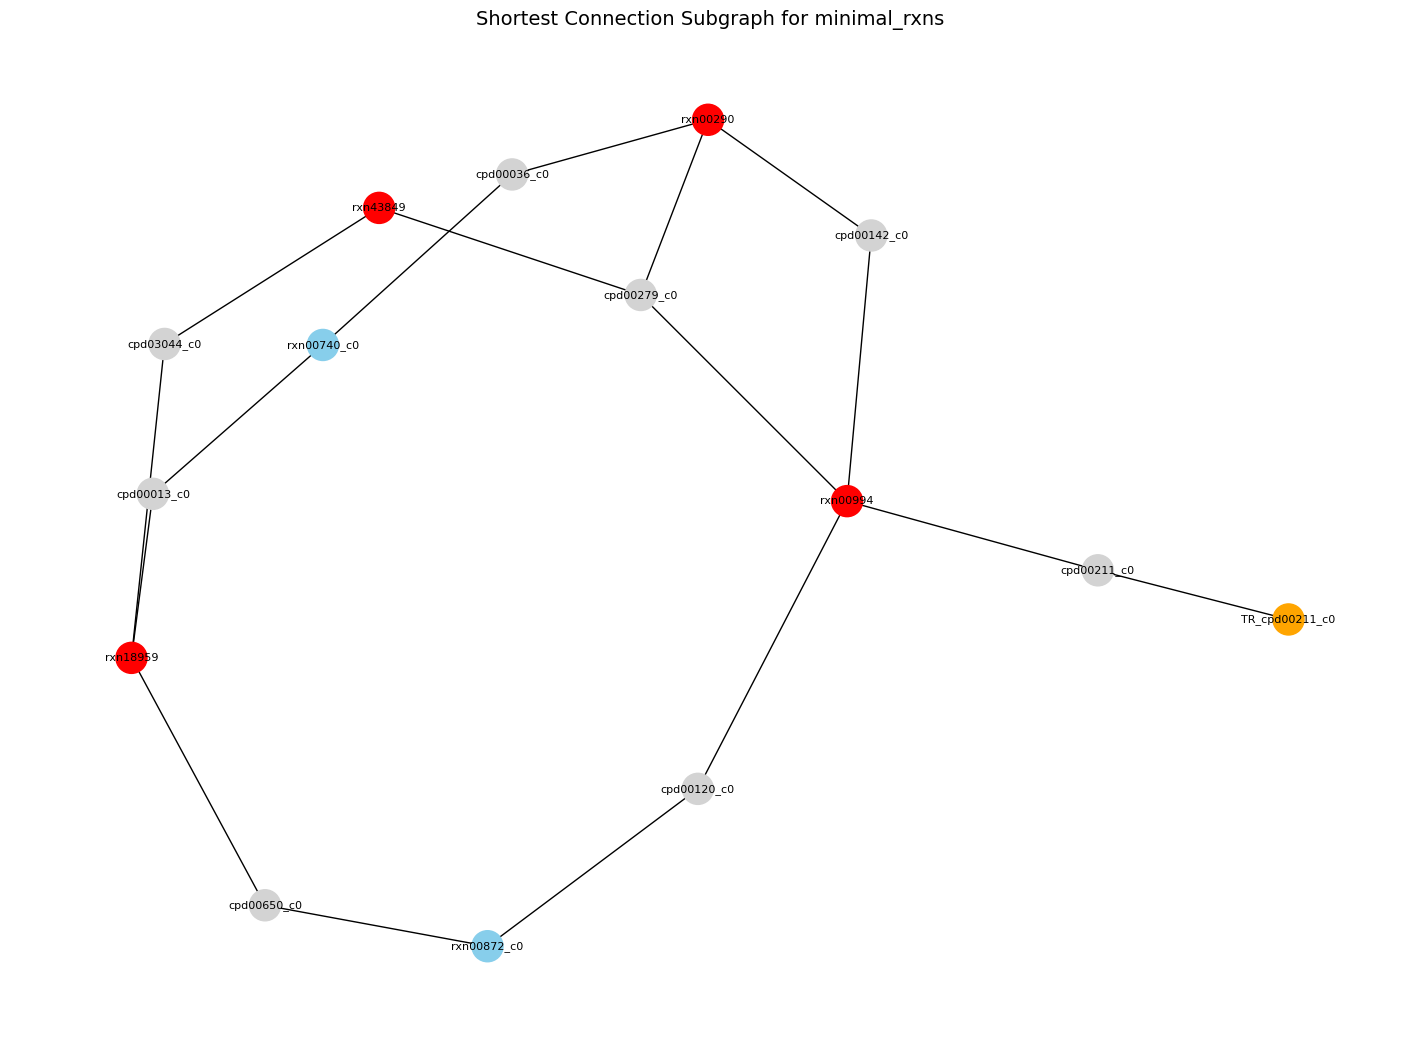

In [76]:
import networkx as nx
from cobra.io import read_sbml_model, save_json_model
from itertools import combinations
import matplotlib.pyplot as plt

# 读取模型
model = read_sbml_model(xml_path)  

# 确定最小必要反应集
butyrate_rxns = []
for rxn in model.metabolites.get_by_id(target_id).reactions:
    if rxn.id not in minimal_rxns:
        minimal_rxns.append(rxn.id)
        butyrate_rxns.append(rxn.id)
        print(f" 加入产丁酸反应: {rxn.id}")

original_rxns = set(minimal_rxns) - set(butyrate_rxns)

# 构建反应-代谢物图（双向无向图）
G = nx.Graph()
for rxn in model.reactions:
    for met in rxn.metabolites:
        G.add_edge(rxn.id, met.id)

# 找到所有两两 minimal_rxns 的最短路径并合并节点
all_paths = []
for a, b in combinations(minimal_rxns, 2):
    try:
        path = nx.shortest_path(G, source=a, target=b)
        all_paths.append(path)
    except nx.NetworkXNoPath:
        print(f" No path between {a} and {b}")

# 构建连通子图
path_nodes = set()
for path in all_paths:
    path_nodes.update(path)

subgraph = G.subgraph(path_nodes).copy()

# 提取子图中所有的反应ID
connected_reactions = [n for n in subgraph.nodes if n in model.reactions]
print(f"\n 最短路径子图包含反应数: {len(connected_reactions)}")
print(" 包含的反应如下:")
for rid in sorted(connected_reactions):
    print(" -", rid)

# 可视化（目标反应红色，其它蓝色）
pos = nx.spring_layout(subgraph, seed=42)
node_colors = []
node_colors = []
for n in subgraph.nodes:
    if n in butyrate_rxns:
        node_colors.append("orange")
    elif n in original_rxns:
        node_colors.append("red")
    elif n in model.reactions:
        node_colors.append("skyblue")
    else:
        node_colors.append("lightgray")

plt.figure(figsize=(14, 10))
nx.draw(subgraph, pos, with_labels=True, node_color=node_colors, node_size=500, font_size=8)
plt.title("Shortest Connection Subgraph for minimal_rxns", fontsize=14)
plt.show()

# 构建子模型
from cobra import Model 
sub_model = Model("minimal_shortest_pathway")
sub_model.add_reactions([model.reactions.get_by_id(rid) for rid in connected_reactions])
save_json_model(sub_model, json_path)
